# Relative Strength Index


In [1]:
# import os
# import sys
# sys.path.insert(0, os.path.abspath('../'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_data

plt.style.use("seaborn")


In [2]:
PATH = "../data/rsi.csv"
stocks = ["MFED.PA", "PE500.PA", "EN.PA", "CNP.PA", "TTE.PA"]


array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

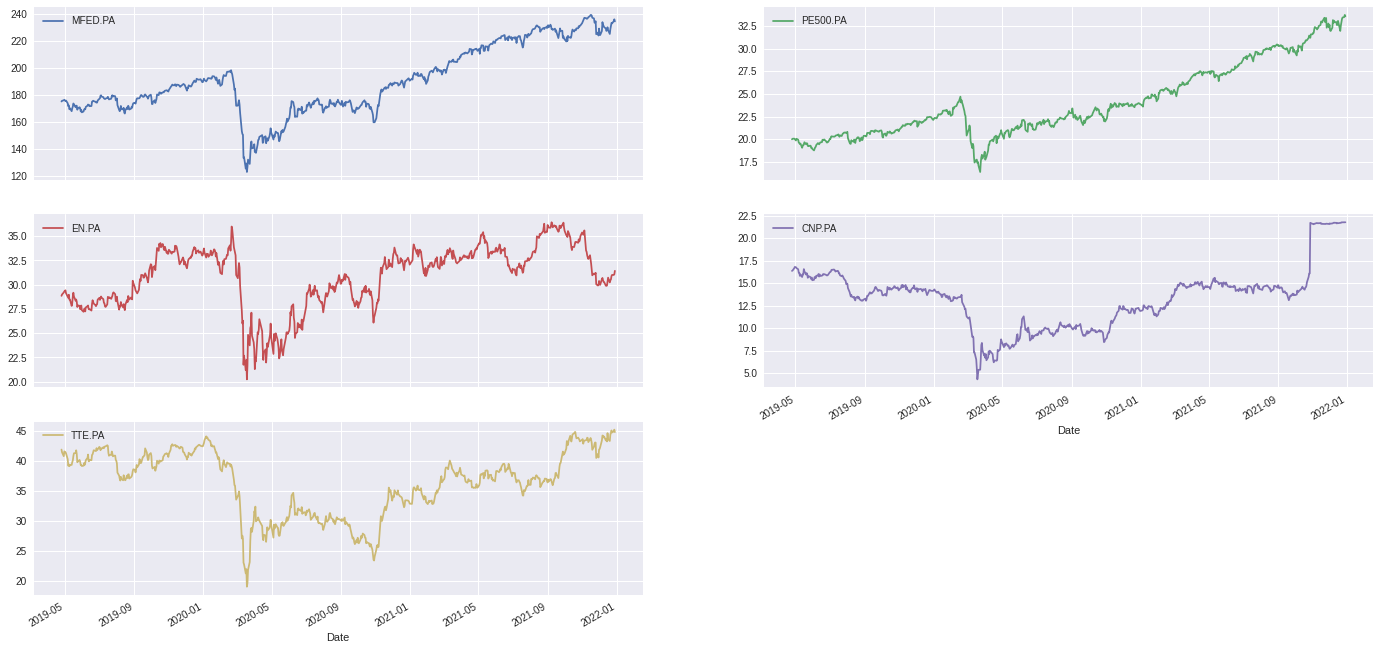

In [3]:
df = get_data(path=PATH, stocks=stocks)

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))


In [4]:
def rsi(df, periods=14, ema=True):
    close_delta = df.diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema:
        ma_up = up.ewm(com=periods - 1, adjust=True, min_periods=periods).mean()
        ma_down = down.ewm(com=periods - 1, adjust=True, min_periods=periods).mean()
    else:
        ma_up = up.rolling(periods).mean()
        ma_down = down.rolling(periods).mean()

    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi.add_suffix("_RSI")


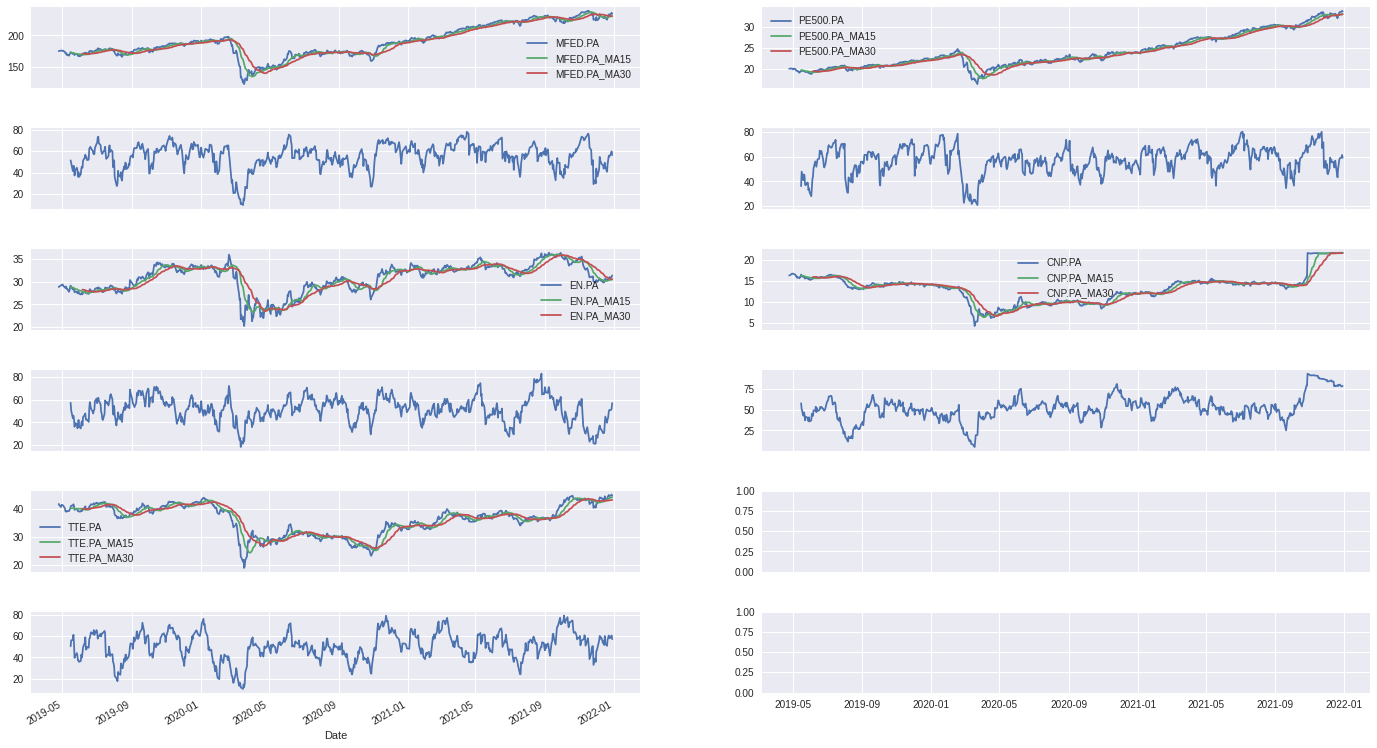

In [5]:
MA1 = 15
MA2 = 30

df = pd.concat(
    [
        df,
        df.rolling(MA1).mean().add_suffix(f"_MA{MA1}"),
        df.rolling(MA2).mean().add_suffix(f"_MA{MA2}"),
        rsi(df),
    ],
    axis=1,
)

fig, axes = plt.subplots(nrows=6, ncols=2, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[[s, f"{s}_MA{MA1}", f"{s}_MA{MA2}"]].plot(
        figsize=(24, 14), ax=axes[i // 2 * 2, i % 2]
    )
    df[f"{s}_RSI"].plot(ax=axes[i // 2 * 2 + 1, i % 2])


## Generate buy signals


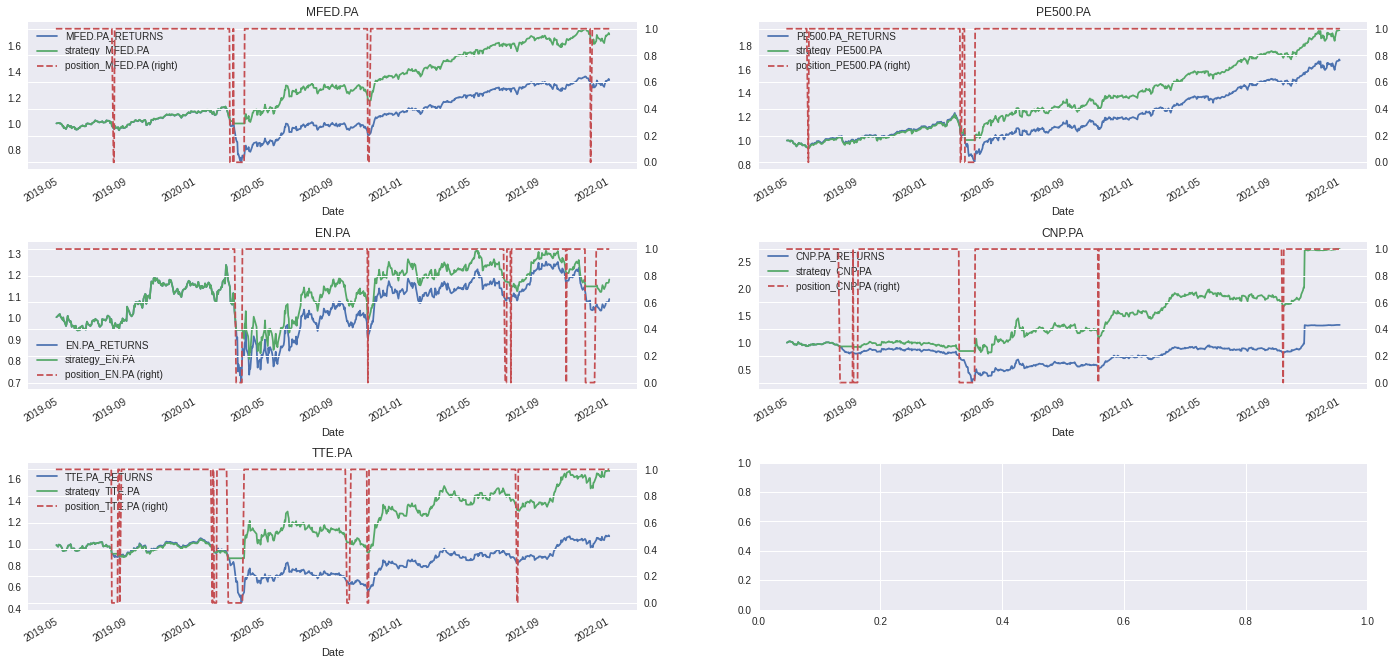

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[f"{s}_RETURNS"] = np.log(df[s] / df[s].shift(1))
    df[f"position_{s}"] = np.where(df[f"{s}_RSI"] < 30, 0, 1)
    df[f"strategy_{s}"] = df[f"position_{s}"].shift(1) * df[f"{s}_RETURNS"]

    ax = (
        df[[f"{s}_RETURNS", f"strategy_{s}"]]
        .cumsum()
        .apply(np.exp)
        .plot(figsize=(24, 12), ax=axes[i // 2, i % 2])
    )
    df[[f"position_{s}"]].plot(
        figsize=(24, 12), ax=ax, secondary_y=f"position_{s}", style="--"
    )
    plt.title(s)


In [31]:
for i, s in enumerate(stocks):
    ret = df[[f"{s}_RETURNS", f"strategy_{s}"]].cumsum().apply(np.exp)

    print(s)
    print(ret.iloc[-1] * 100)
    print()


MFED.PA
MFED.PA_RETURNS     133.870413
strategy_MFED.PA    169.207492
Name: 2021-12-29 00:00:00, dtype: float64

PE500.PA
PE500.PA_RETURNS     167.765007
strategy_PE500.PA    193.451280
Name: 2021-12-29 00:00:00, dtype: float64

EN.PA
EN.PA_RETURNS     108.925456
strategy_EN.PA    118.017286
Name: 2021-12-29 00:00:00, dtype: float64

CNP.PA
CNP.PA_RETURNS     132.984788
strategy_CNP.PA    273.187015
Name: 2021-12-29 00:00:00, dtype: float64

TTE.PA
TTE.PA_RETURNS     106.951763
strategy_TTE.PA    167.226280
Name: 2021-12-29 00:00:00, dtype: float64

